In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import numpy as np
from numpy.typing import NDArray
import pandas as pd
import ruptures as rpt
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from tokenizers.fixed import fixed_segmentation
from tokenizers.cpd import cpd_segmentation

# Load Dataset

In [2]:
import pandas as pd
from numpy.typing import NDArray
from typing import List
import numpy as np
import torch
import ruptures as rpt
import matplotlib.pyplot as plt
import wfdb
import ast
import torch.nn.functional as F

def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

def load_data(path, sampling_rate):
    """
    Loads time series data.
    :param file_path: Path to data
    :return: Array of time series data
    """
    # load and convert annotation data
    Y = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id')
    Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

    # Load raw signal data
    X = load_raw_data(Y, sampling_rate, path)

    # Load scp_statements.csv for diagnostic aggregation
    agg_df = pd.read_csv(path+'scp_statements.csv', index_col=0)
    agg_df = agg_df[agg_df.diagnostic == 1]

    def aggregate_diagnostic(y_dic):
        tmp = []
        for key in y_dic.keys():
            if key in agg_df.index:
                tmp.append(agg_df.loc[key].diagnostic_class)
        return list(set(tmp))

    # Apply diagnostic superclass
    Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)

    # Split data into train and test
    test_fold = 10
    # Train
    X_train = X[np.where(Y.strat_fold != test_fold)]
    y_train = Y[(Y.strat_fold != test_fold)].diagnostic_superclass
    # Test
    X_test = X[np.where(Y.strat_fold == test_fold)]
    y_test = Y[Y.strat_fold == test_fold].diagnostic_superclass

    return X_train, y_train, X_test, y_test

In [10]:
path = './datasets/ecg/WFDB_PTBXL/ptbxl/'
sampling_rate=100
X_train, y_train, X_test, y_test = load_data(path, sampling_rate)

# preprocess data without labels
mask = y_train.apply(lambda x: isinstance(x, list) and len(x) > 0)
y_train = y_train[mask]
X_train = X_train[mask]
y_train = y_train.apply(lambda x: x[0]).astype('category')
y_train = torch.tensor(y_train.cat.codes.values, dtype=torch.long)

print(torch.unique(y_train))

tensor([0, 1, 2, 3, 4])


# Preprocess

In [7]:
from scipy.signal import butter, filtfilt

def butter_bandpass(lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(data, lowcut, highcut, fs, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    return filtfilt(b, a, data, axis=0)

def moving_average_filter(data, window_size=5):
    # Check if data is 1D or 2D
    if data.ndim == 1:
        return np.convolve(data, np.ones(window_size) / window_size, mode='same')
    elif data.ndim == 2:
        return np.array([np.convolve(data[:, i], np.ones(window_size) / window_size, mode='same') for i in range(data.shape[1])]).T
    else:
        raise ValueError("Input data must be 1D or 2D.")


def z_score_normalize(data):
    return (data - np.mean(data, axis=0)) / np.std(data, axis=0)

# Visualize

In [11]:
ECG_LABELS = ["I", "II", "III", "aVR", "aVL", "aVF", "V1", "V2", "V3", "V4", "V5", "V6"]

Time took: 0.03652596473693848


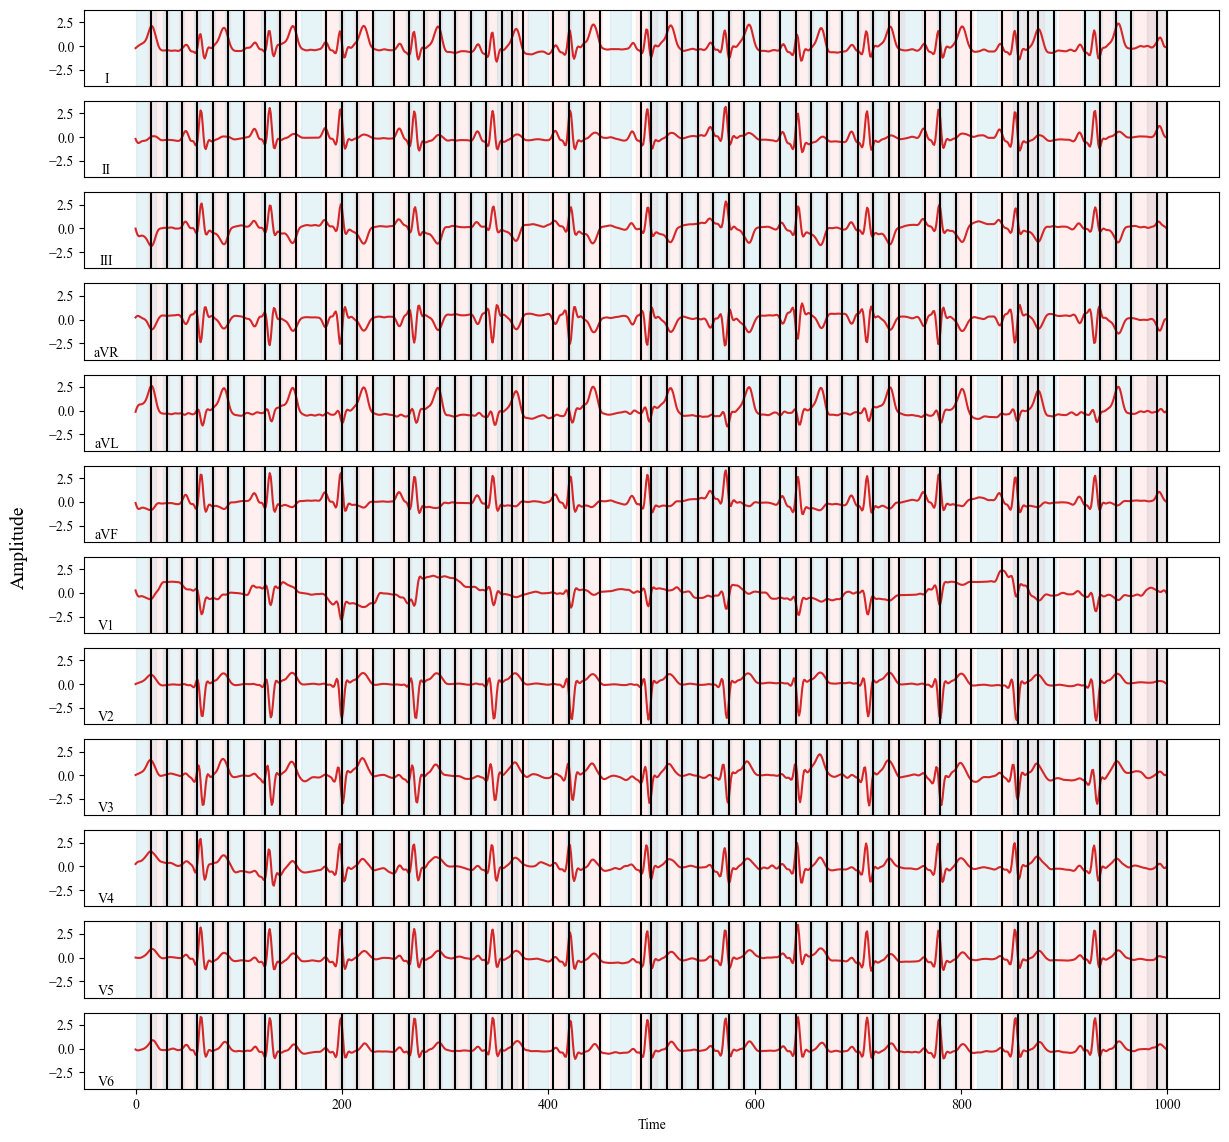

Time took: 0.015455961227416992


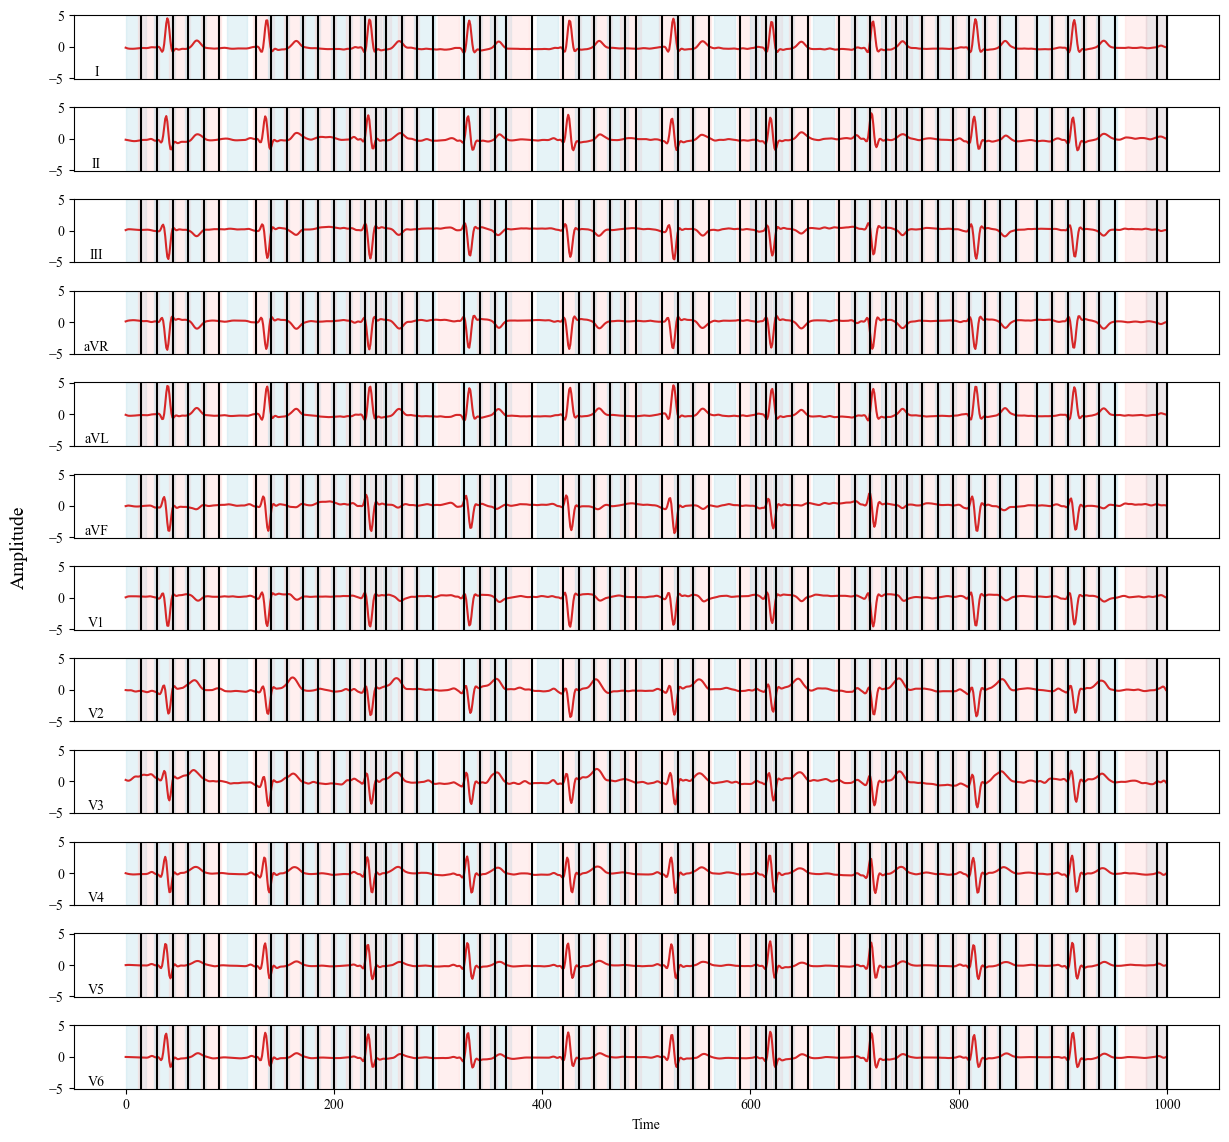

Time took: 0.012949943542480469


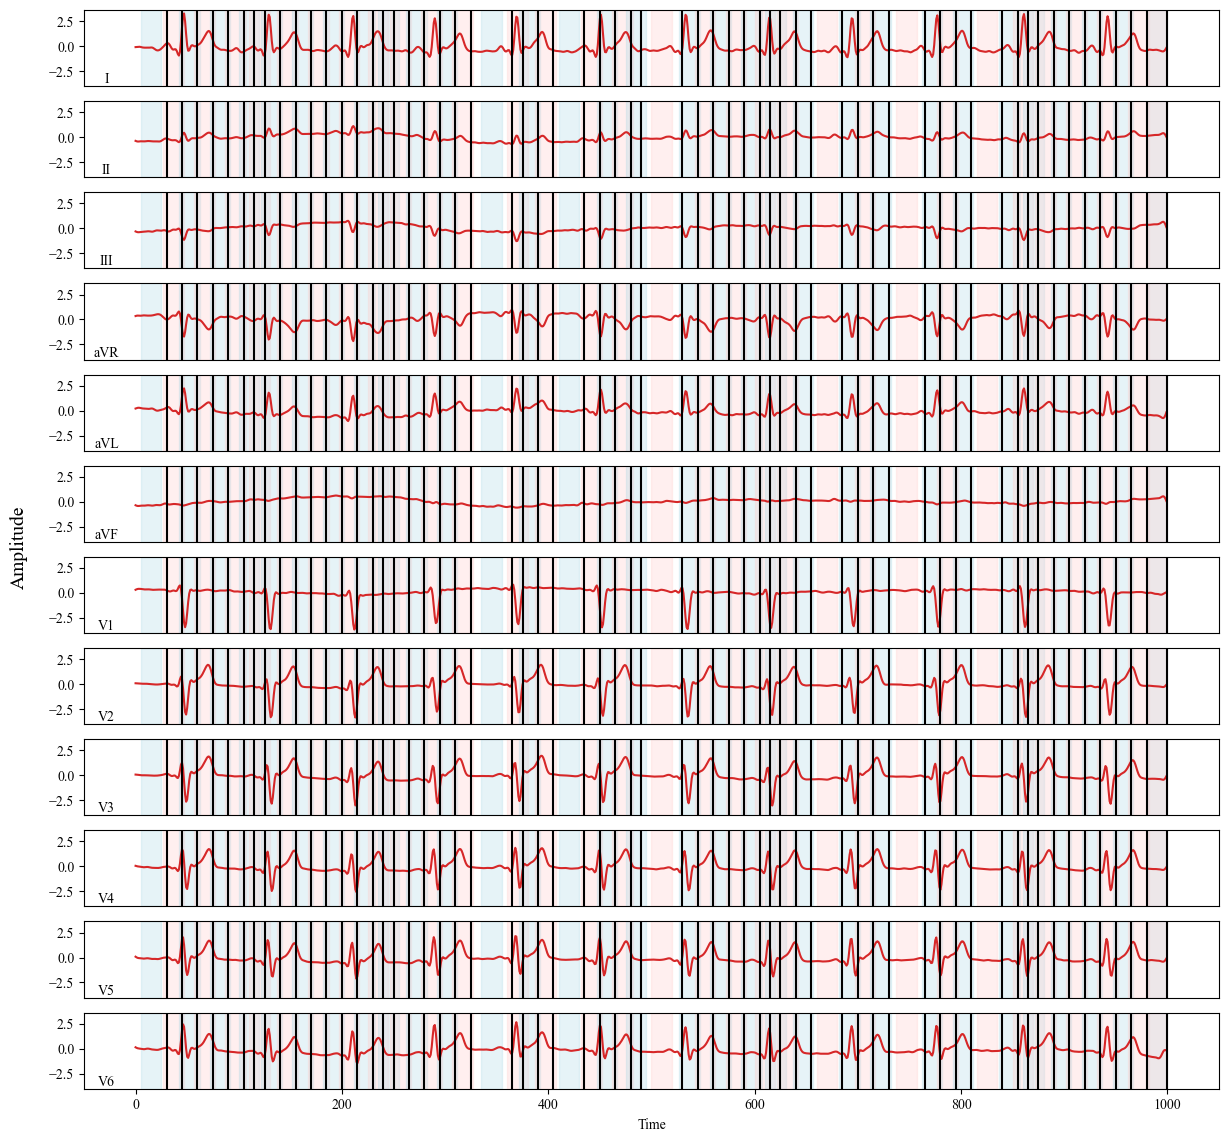

Time took: 0.018316030502319336


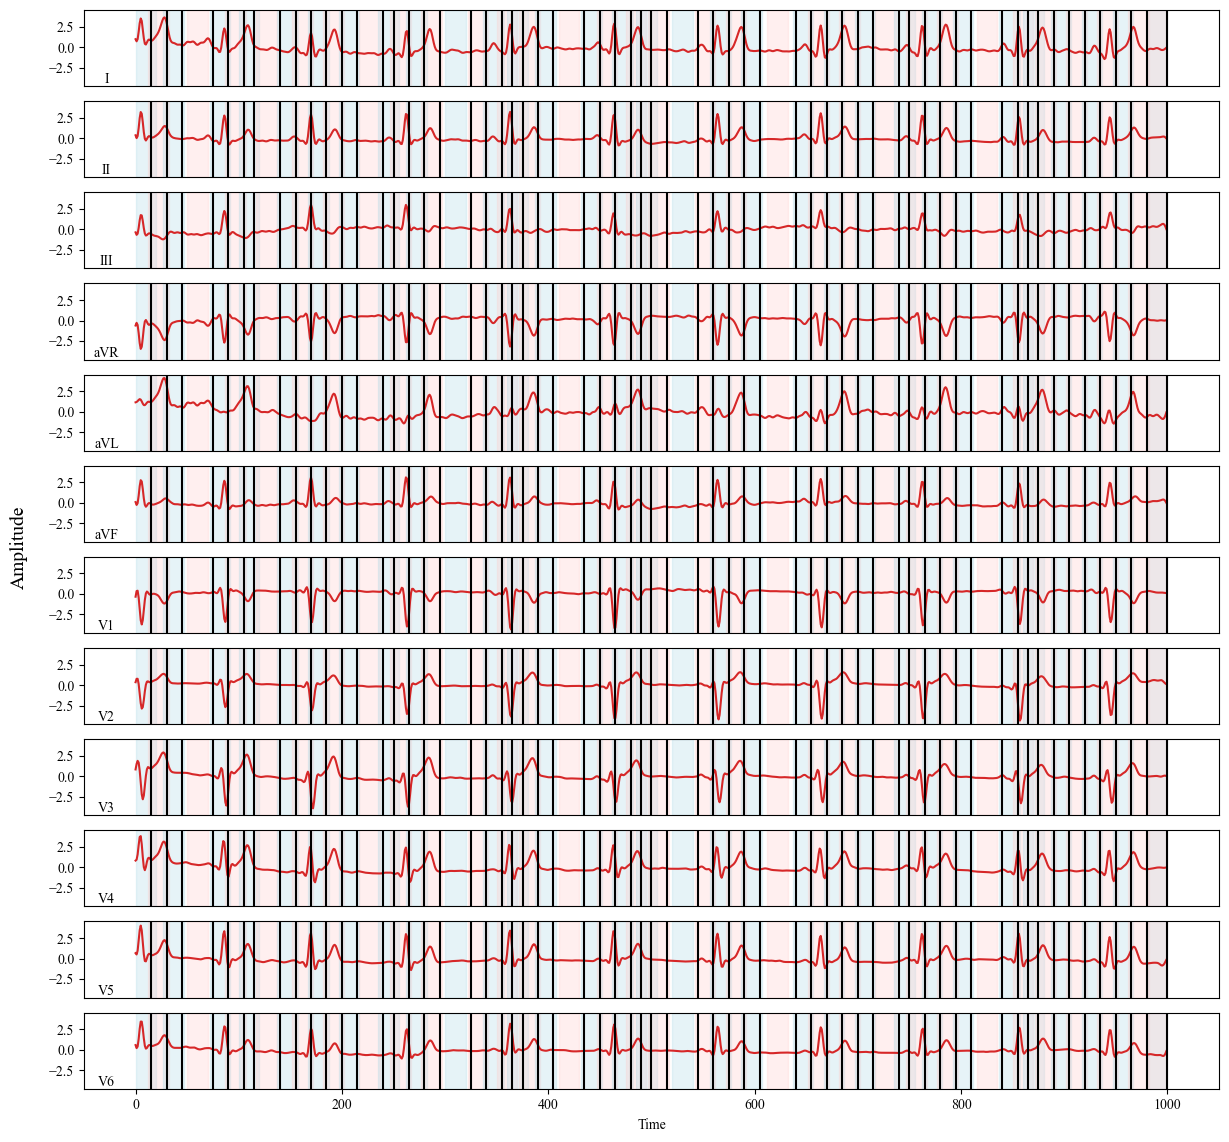

Time took: 0.01394200325012207


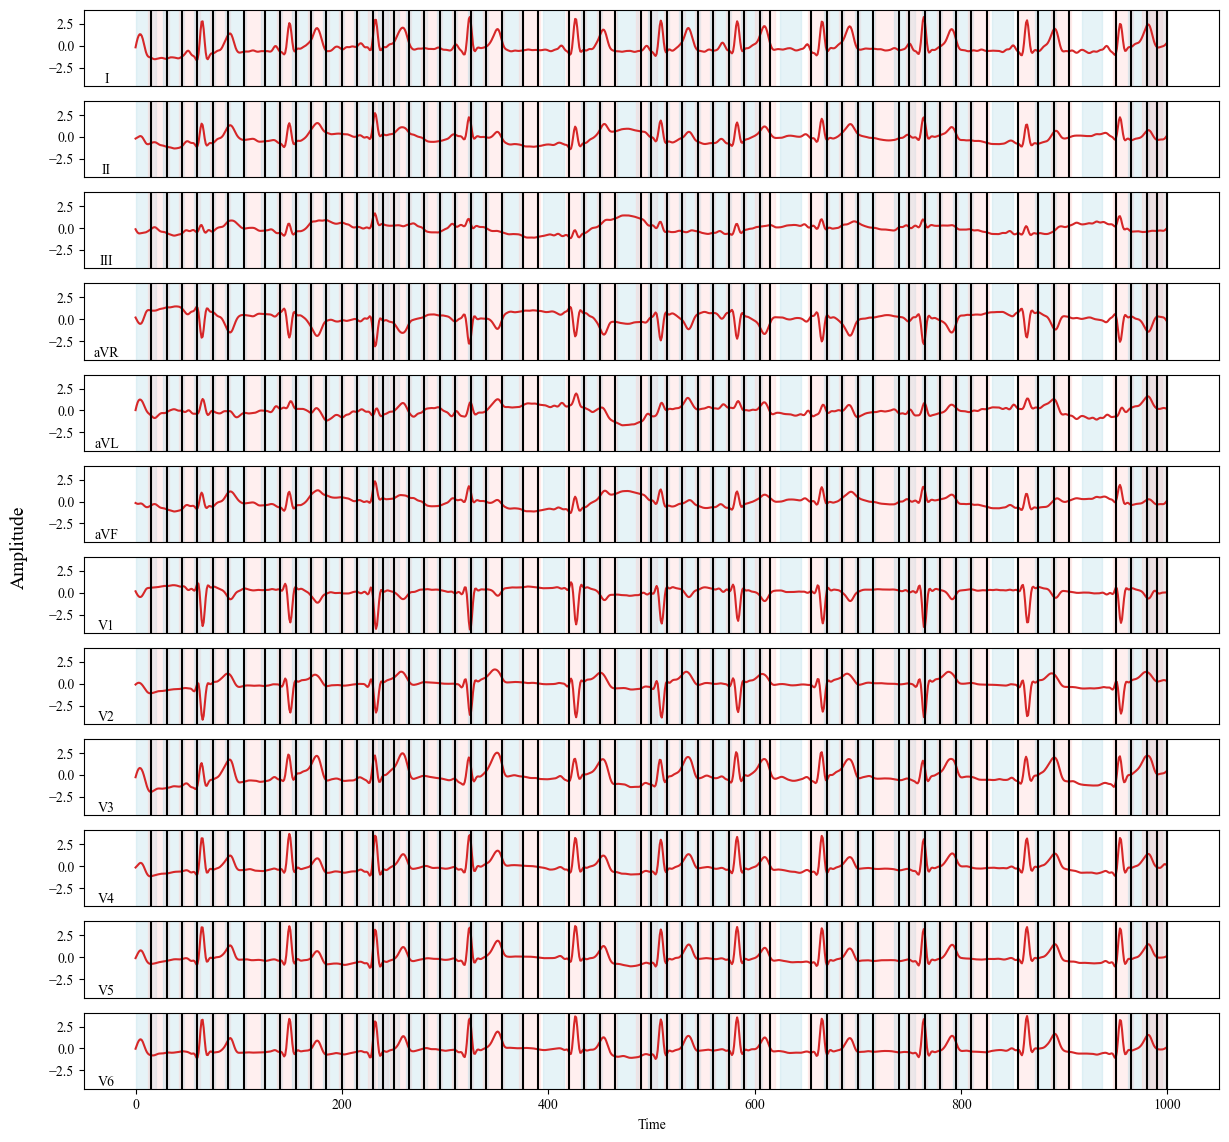

In [45]:
import time

model = 'bottomup'  # Change point detection model
segment_length = 20
pen = 60
n_bkps= 10
min_size = 10
for time_series_idx, time_series in enumerate(X_train[5:10]):
    for lead in range(time_series.shape[1]):  # Normalize each channel independently
        time_series[:, lead] = z_score_normalize(time_series[:, lead])
    time_series = moving_average_filter(time_series, window_size=3)
    time_series = bandpass_filter(time_series, 0.5, 40, fs=250)
    time_series = np.ascontiguousarray(time_series)

    # Create a figure with subplots (12 channels in a single column)
    fig, axs = plt.subplots(12, 1, figsize=(12, 12), sharey=True)
    plt.rcParams.update({'font.family': 'Times New Roman'})

    start_time = time.time()
    segments, change_points, intervals = cpd_segmentation(torch.tensor(time_series), model, segment_length, pen, min_size, n_bkps)
    print("Time took:", time.time() - start_time)
    # rpt.display(time_series, change_points)
    
    # Loop through each of the 12 ECG channels
    for i in range(time_series.shape[1]):
        channel_data = time_series[:, i]  # Extract data for the i-th channel (lead)
        axs[i].plot(channel_data, label=f"Channel {i+1}", color='#d62728')


        # Add vertical lines for each detected change point
        for cp in change_points[1:-1]:
            axs[i].axvline(x=cp, color='black', label=f"Change Point {cp}" if i == 0 else "")

        if i == 11:
            axs[i].set_xlabel('Time')
        else:
            axs[i].tick_params(axis='x', which='both', bottom=False, labelbottom=False)  # Remove x-axis ticks

        axs[i].set_ylabel(ECG_LABELS[i], rotation=0, labelpad=10)
        axs[i].yaxis.set_label_coords(0.02, 0)

        # Loop through segments to color the background
        for idx, (seg_start, seg_end) in enumerate(intervals):
            color = '#add8e6' if idx % 2 == 0 else '#ffcccb'  # Light blue and light red
            axs[i].axvspan(seg_start, seg_end, color=color, alpha=0.3, zorder=0)

    # Adjust layout to avoid overlap
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for the main title
    fig.text(-0.02, 0.5, 'Amplitude', va='center', rotation='vertical', fontsize=14)

    # Show the plot for the current time series
    plt.savefig("wave.png", format="png", dpi=300, bbox_inches='tight')
    plt.show()